In [1]:
import math
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
import warnings
import datetime
import time

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use(style='seaborn')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sampleSubmission.csv')

In [3]:
print(train.shape)
print(test.shape)

(10886, 12)
(6493, 9)


In [4]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [6]:
sample.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


# Columns Info
### datetime - hourly date + timestamp  
### season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
### holiday - whether the day is considered a holiday
### workingday - whether the day is neither a weekend nor holiday
### weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
##### 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
##### 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
### 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
### temp - temperature in Celsius
### atemp - "feels like" temperature in Celsius
### humidity - relative humidity
### windspeed - wind speed
### casual - number of non-registered user rentals initiated
### registered - number of registered user rentals initiated
### count - number of total rentals

# Objective:
## count of bikes rented during each hour 

In [7]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [8]:
print(train.isnull().sum())
print(test.isnull().sum())

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64


## Okay feels good for not having any null values
.

# We have to figure outsome way to deal with this dateime column

In [9]:
train['datetime']

0        2011-01-01 00:00:00
1        2011-01-01 01:00:00
2        2011-01-01 02:00:00
3        2011-01-01 03:00:00
4        2011-01-01 04:00:00
                ...         
10881    2012-12-19 19:00:00
10882    2012-12-19 20:00:00
10883    2012-12-19 21:00:00
10884    2012-12-19 22:00:00
10885    2012-12-19 23:00:00
Name: datetime, Length: 10886, dtype: object

# Splitting the datetime column for (hour, day, month, year) columns will be good enough here

In [10]:
# Training set
train['hour'] = [t.hour for t in pd.DatetimeIndex(train['datetime'])]
train['day'] = [t.day for t in pd.DatetimeIndex(train['datetime'])]
train['month'] = [t.month for t in pd.DatetimeIndex(train['datetime'])]
train['year'] = [t.year for t in pd.DatetimeIndex(train['datetime'])]
train.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month,year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,0,1,1,2011
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1,1,1,2011
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2,1,1,2011
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,3,1,1,2011
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,4,1,1,2011
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,5,1,1,2011
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2,6,1,1,2011
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3,7,1,1,2011
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8,8,1,1,2011
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14,9,1,1,2011


In [11]:
# Testing set
test['hour'] = [t.hour for t in pd.DatetimeIndex(test['datetime'])]
test['day'] = [t.day for t in pd.DatetimeIndex(test['datetime'])]
test['month'] = [t.month for t in pd.DatetimeIndex(test['datetime'])]
test['year'] = [t.year for t in pd.DatetimeIndex(test['datetime'])]
test.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month,year
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,0,20,1,2011
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,20,1,2011
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2,20,1,2011
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,20,1,2011
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,4,20,1,2011
5,2011-01-20 05:00:00,1,0,1,1,9.84,11.365,60,15.0013,5,20,1,2011
6,2011-01-20 06:00:00,1,0,1,1,9.02,10.605,60,15.0013,6,20,1,2011
7,2011-01-20 07:00:00,1,0,1,1,9.02,10.605,55,15.0013,7,20,1,2011
8,2011-01-20 08:00:00,1,0,1,1,9.02,10.605,55,19.0012,8,20,1,2011
9,2011-01-20 09:00:00,1,0,1,2,9.84,11.365,52,15.0013,9,20,1,2011


In [12]:
# Get the test id
test_id = test['datetime']
test_id

0       2011-01-20 00:00:00
1       2011-01-20 01:00:00
2       2011-01-20 02:00:00
3       2011-01-20 03:00:00
4       2011-01-20 04:00:00
               ...         
6488    2012-12-31 19:00:00
6489    2012-12-31 20:00:00
6490    2012-12-31 21:00:00
6491    2012-12-31 22:00:00
6492    2012-12-31 23:00:00
Name: datetime, Length: 6493, dtype: object

In [13]:
print(train.shape)
print(test.shape)

(10886, 16)
(6493, 13)


In [14]:
# Drop extra columns at the training set
train.drop(['casual', 'registered'], axis=1, inplace=True)
print(train.shape)
print(test.shape)

(10886, 14)
(6493, 13)


# Analysis

<AxesSubplot:xlabel='count'>

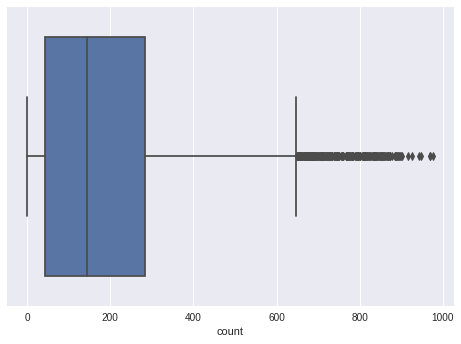

In [15]:
sns.boxplot(train['count'])

<AxesSubplot:xlabel='count', ylabel='Density'>

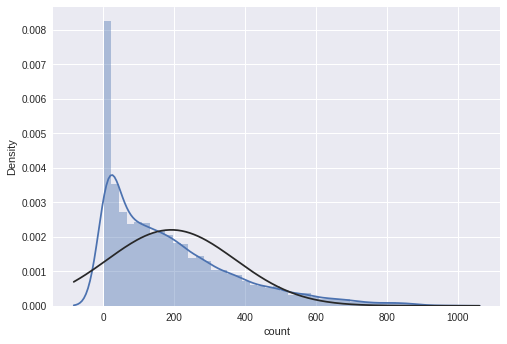

In [16]:
sns.distplot(train['count'], fit=norm)

### The data is highly skewed, we have to handle that

### using the log function to handle the skewness of the data

In [17]:
train['count']

0         16
1         40
2         32
3         13
4          1
        ... 
10881    336
10882    241
10883    168
10884    129
10885     88
Name: count, Length: 10886, dtype: int64

In [18]:
train['count'] = np.log(train['count'])
train['count']

0        2.772589
1        3.688879
2        3.465736
3        2.564949
4        0.000000
           ...   
10881    5.817111
10882    5.484797
10883    5.123964
10884    4.859812
10885    4.477337
Name: count, Length: 10886, dtype: float64

<AxesSubplot:xlabel='count', ylabel='Density'>

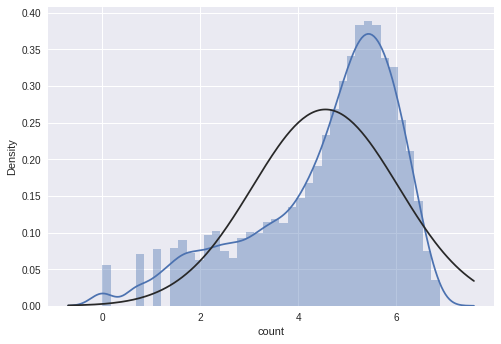

In [19]:
sns.distplot(train['count'], fit=norm)

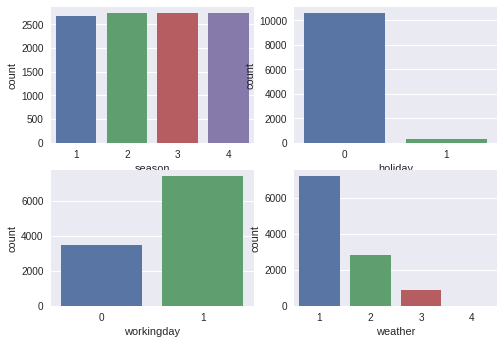

In [20]:
cat_features = ['season', 'holiday', 'workingday', 'weather']
i = 1
for col in cat_features:
    plt.subplot(2, 2, i)
    i += 1
    sns.countplot(train[col])
plt.show()

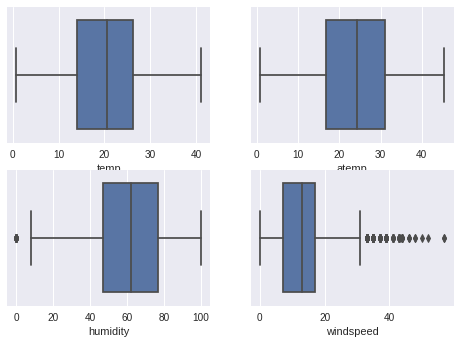

In [21]:
num_features = ['temp', 'atemp', 'humidity', 'windspeed']
i = 1
for col in num_features:
    plt.subplot(2, 2, i)
    i += 1
    sns.boxplot(train[col]) 

plt.show()

### Some of the conclusions that can be made:

- Holiday and working day look somewhat correlated. Can one of them be removed to avoid multi-collinearity? Let's wait until we calculate thier correlation value
- Temp, Atemp, humidity look normally distributed. However, windspeed has a lot of outliers which will be analysed further.
- doing a brief time-series analysis to see if there's any improvement in count over a period of time
- moving average to be calculated for a period of 3/4 months as that is the no of months in one season

# Correaltions

<AxesSubplot:>

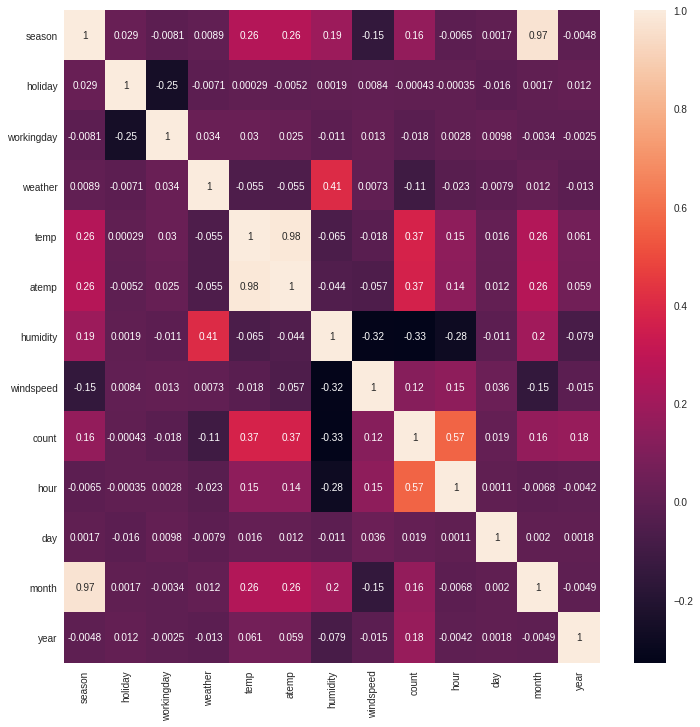

In [22]:
corr = train.corr()
plt.subplots(figsize=(12, 12))
sns.heatmap(corr, annot=True)

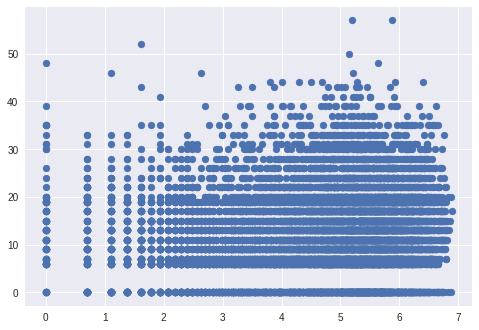

In [23]:
plt.scatter(train['count'], train['windspeed'])
plt.show()

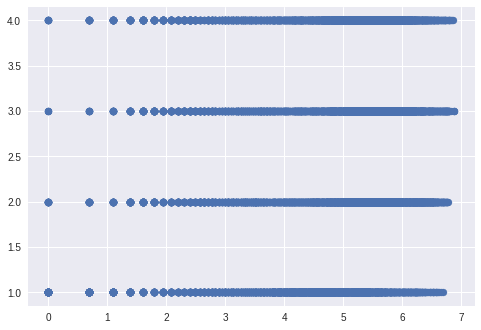

In [24]:
plt.scatter(train['count'], train['season'])
plt.show()

<AxesSubplot:xlabel='season', ylabel='Density'>

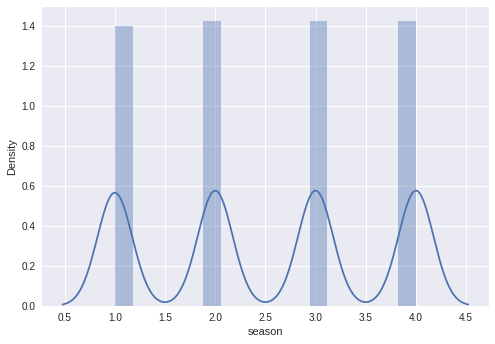

In [25]:
sns.distplot(train['season'])

In [26]:
train.skew()

season       -0.007076
holiday       5.660517
workingday   -0.776163
weather       1.243484
temp          0.003691
atemp        -0.102560
humidity     -0.086335
windspeed     0.588767
count        -0.971228
hour         -0.009125
day           0.001182
month        -0.005237
year         -0.007717
dtype: float64

<AxesSubplot:xlabel='holiday', ylabel='Density'>

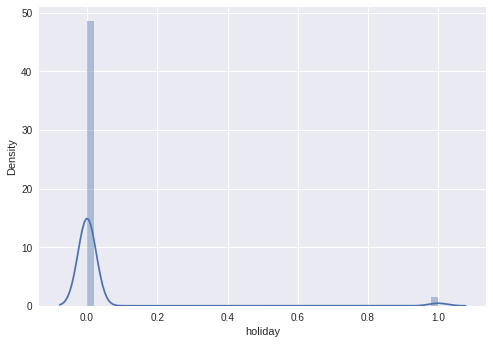

In [27]:
sns.distplot(train['holiday'])

In [31]:
train.drop(['holiday'], axis=1, inplace=True)
test.drop(['holiday'], axis=1, inplace=True)

In [32]:
train.dtypes

datetime       object
season          int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
count         float64
hour            int64
day             int64
month           int64
year            int64
dtype: object

In [33]:
target = train['count']
train.drop(['datetime', 'count'], axis=1, inplace=True)
test.drop(['datetime'], axis=1, inplace=True)
print(train.shape)
print(test.shape)

(10886, 11)
(6493, 11)


In [34]:
target

0        2.772589
1        3.688879
2        3.465736
3        2.564949
4        0.000000
           ...   
10881    5.817111
10882    5.484797
10883    5.123964
10884    4.859812
10885    4.477337
Name: count, Length: 10886, dtype: float64

# Modelling

In [35]:
# XGBoost
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, random_state =7, nthread = -1)
model_xgb.fit(train, target)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1.7817, missing=nan, monotone_constraints='()',
             n_estimators=2200, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
             scale_pos_weight=1, subsample=0.5213, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [36]:
# y_pred = model_xgb.predict(np.floor(np.exp(test)))
y_pred = model_xgb.predict(test)
y_pred = np.exp(y_pred)
y_pred

array([  9.706895 ,   4.6524215,   2.7166123, ..., 153.32362  ,
       105.741    ,  69.36771  ], dtype=float32)

In [37]:
sub = pd.DataFrame()
sub['datetime'] = test_id
sub['count'] = y_pred
sub.to_csv('submission5.csv', index=False)